# 2D convolution network with Adam optimizer (Functional model)

## This is very first functional model instead of sequential one. Due to that facts there are few issues related with this model:
* model cannot use big batch_size, there is an error related with OOM (Out of memory)
* model got troubles with uninitialization, probable because of using tensorflow backend instead of theano
* model is NOT learning. After whole 5 epochs I decided to interupt because there is no sense in running it it accuracy and loss hadn't changed since beginning

## My previous assumption was wrong, actually the model is learning and it is performing very well
In comparison to the sequential model with same data set and optimizer (Adam), same layers and layers structure the difference is pretty distinctive. However, there are little differences in the count of params to be learned (25M compare to 17M in sequential one) which presumably made that difference in assumptions. I have to dive into documentation to work on this.
##### Nonetheless here are results:
Functional API model: 
* accuracy: 0.9517
* loss: 0.1445

Sequential model:
* accuracy: 0.5565
* loss: 1.0111

In [1]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from PIL import Image

import numpy as np
from numpy.testing import assert_allclose, assert_equal
import matplotlib
import matplotlib.pyplot as plt
import os

# initialization and check if dataset got proper size

path = '/home/ubuntu/zdjecia/'
# path = '/home/oziomek/licencjat/kostki/zdjecia/'
listing = os.listdir(path)
print(listing)
num_samples = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        num_samples += len(os.listdir(path + folder + '/' + str(i)))
assert_equal(100800, num_samples)
print(num_samples)

Using TensorFlow backend.


['woodOnRed', 'blackOnRed', 'redOnRed', 'redOnRed_white', 'navyOnWhite', 'blackOnBlack', 'whiteOnBlue', 'greenOnWhite', 'navyOnBlue', 'stainOnWhite', 'hardLight', 'whiteOnRed_distance', 'whiteOnBlack', 'whiteOnRed', 'greenOnGreen']
100800


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load all data into numpy array
immatrix = np.array(
    [np.array(Image.open(path + folder + '/' + str(i) + '/' + file)).flatten() 
         for folder in os.listdir(path)
             for i in range(1, 7) 
                 for file in os.listdir(path + folder + '/' + str(i))], 'f')

In [3]:
print(immatrix.shape)

(100800, 4096)


In [4]:
labels = np.ones((num_samples, ), dtype=int)
counter = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        samples = len(os.listdir(path + folder + '/' + str(i)))
        labels[counter:counter+samples] = i-1
        counter += samples

In [5]:
# randomize data with const random_state
data, label = shuffle(immatrix, labels, random_state=13)

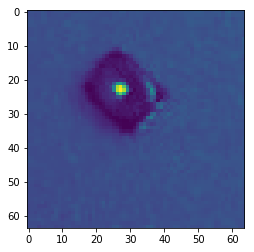

There are 1 dots, number is 3680


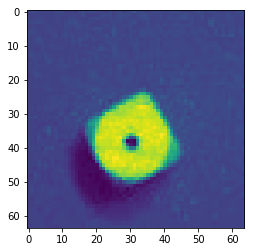

There are 1 dots, number is 316


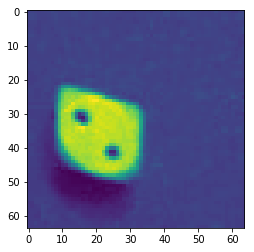

There are 2 dots, number is 791


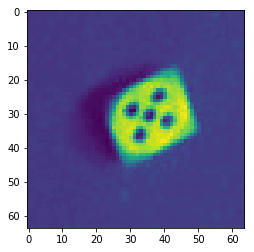

There are 5 dots, number is 2368


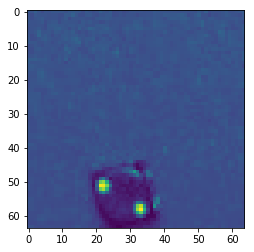

There are 2 dots, number is 6219


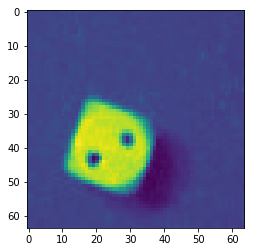

There are 2 dots, number is 834


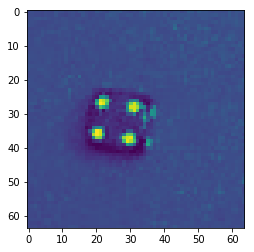

There are 4 dots, number is 9466


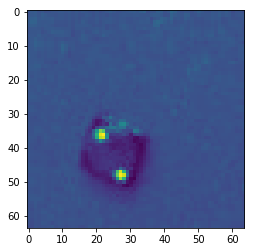

There are 2 dots, number is 5378


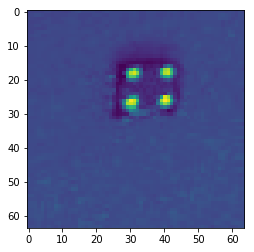

There are 4 dots, number is 9700


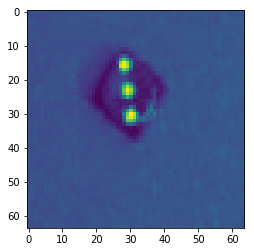

There are 3 dots, number is 7454


In [6]:
# show randomly chosen image
rows, cols = 64, 64
labels_values = 6
train_data = [data, label]
import random
for i in range(10):
    random_image = random.randint(0, 10080)
    img=immatrix[random_image].reshape(rows, cols)
    plt.imshow(img)
    plt.show()
    print("There are {} dots, number is {}".format(labels[random_image] + 1, random_image))

In [7]:
(X, y) = (train_data[0], train_data[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [8]:
# reshape to [color_layers][pixels_height][pixels_width], color_layers equal to 2 because photos are in GRAYSCALE
X_train = X_train.reshape(X_train.shape[0], rows, cols, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], rows, cols, 1).astype('float32')

# normalize to 0-1
X_train /= 255
X_test /= 255

print(X_train.shape, X_test.shape)

(80640, 64, 64, 1) (20160, 64, 64, 1)


In [9]:
# onehot
y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)
print(y_train.shape, y_test.shape)

(80640, 6) (20160, 6)


In [14]:
# create functional model with 2NN layers

visible = Input(shape=(64, 64, 1))

conv1 = Conv2D(64, kernel_size=5, padding='same', activation='relu')(visible)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(32, kernel_size=5, padding='same', activation='relu')(pool1)
dropout1 = Dropout(0.2)(conv2)
flat1 = Flatten()(dropout1)
hidden1 = Dense(784, kernel_initializer='random_uniform', activation='relu')(flat1)
dropout2 = Dropout(0.2)(hidden1)
hidden2 = Dense(196, kernel_initializer='random_uniform', activation='relu')(dropout2)
dropout3 = Dropout(0.2)(hidden2)
hidden3 = Dense(64, kernel_initializer='random_uniform', activation='relu')(dropout3)
predictions = Dense(labels_values, activation='softmax')(hidden3)
model = Model(inputs=visible, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# summarize model and apply checkpoints
print(model.summary())
filepath = 'model2API-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        51232     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               25690896  
__________

In [16]:
# visualization of a model
plot_model(model, to_file='model2API_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=1024, verbose=1, callbacks=callbacks_list)

Train on 80640 samples, validate on 20160 samples
Epoch 1/25
80640/80640 [==============================] - 46s 569us/step - loss: 1.5967 - acc: 0.3028 - val_loss: 1.3320 - val_acc: 0.4525
Epoch 2/25
80640/80640 [==============================] - 45s 564us/step - loss: 1.2220 - acc: 0.4716 - val_loss: 1.0512 - val_acc: 0.5166
Epoch 3/25
80640/80640 [==============================] - 45s 562us/step - loss: 0.9876 - acc: 0.5524 - val_loss: 0.9638 - val_acc: 0.5766
Epoch 4/25
80640/80640 [==============================] - 45s 562us/step - loss: 0.8157 - acc: 0.6260 - val_loss: 0.6754 - val_acc: 0.6996
Epoch 5/25
80640/80640 [==============================] - 45s 564us/step - loss: 0.6741 - acc: 0.6949 - val_loss: 0.5557 - val_acc: 0.7666
Epoch 6/25
80640/80640 [==============================] - 45s 564us/step - loss: 0.6434 - acc: 0.7165 - val_loss: 0.4659 - val_acc: 0.8096
Epoch 7/25
80640/80640 [==============================] - 45s 564us/step - loss: 0.4992 - acc: 0.7836 - val_loss: 0.

In [18]:
score = model.evaluate(X_test, y_test, verbose=1)

20160/20160 [==============================] - 6s 281us/step


In [19]:
print(history.history.keys())
print("Accuracy: %.2f%%" % (score[1]*100))
print('Test loss:', score[0])
print('Test accuracy', score[1])

dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])
Accuracy: 95.17%
Test loss: 0.1444753410412915
Test accuracy 0.9517361111111111


In [20]:
print('training results:')
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(score[i]))

training results:
loss: 0.1444753410412915
acc: 0.9517361111111111


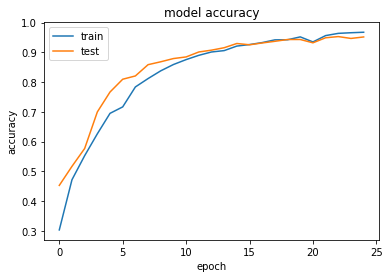

In [21]:
#summarize for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

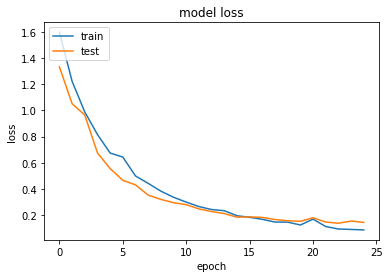

In [22]:
#summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
model_json = model.to_json()
with open('model2API_model.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model2API_weights.h5')
print('Saved model weights')

Saved model weights


In [ ]:
new_model = load_model('model2-25-0.0074.h5')
# check in models are similar to the given tolerance
# assert_allclose(model.predict(X_train),
#                new_model.predict(X_train),
#                1e-4)

In [ ]:
filepath = 'model2API_continue-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
new_history = new_model.fit(X_train, y_train, epochs=10, batch_size=2048, callbacks=callbacks_list)

In [ ]:
new_score = new_model.evaluate(X_test, y_test, verbose=1)
print('training results:')
for i in range(len(new_model.metrics_names)):
    print(str(new_model.metrics_names[i]) + ": " + str(new_score[i]))


In [ ]:
model_json = model.to_json()
with open('model2API_continue.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model2API_weights_continue.h5')
print('Saved model weights')